## ThinkDSP

This notebook contains

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

### Do we hear phase?

This notebook investigates what effect, if any, changes in phase have on our perception of sound.

I'll start with a simple waveform, a sawtooth, and move on to more natural sounds.

In [3]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=500, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.make_audio()

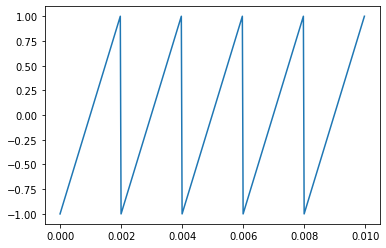

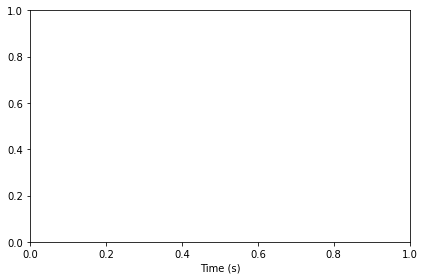

In [4]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

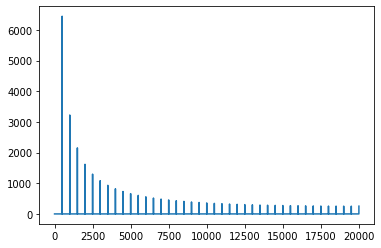

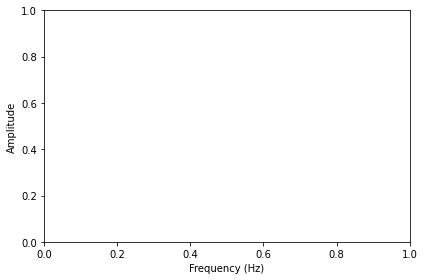

In [5]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

The following function plots the angle part of the spectrum.

In [6]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

At most frequencies, the amplitude is small and the angle is pretty much a random number.  So if we plot all of the angles, it's a bit of a mess.

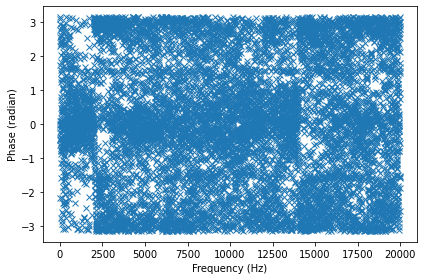

In [7]:
plot_angle(spectrum, thresh=0)

But if we select only the frequencies where the magnitude exceeds a threshold, we see that there is a structure in the angles.  Each harmonic is offset from the previous one by a fraction of a radian.

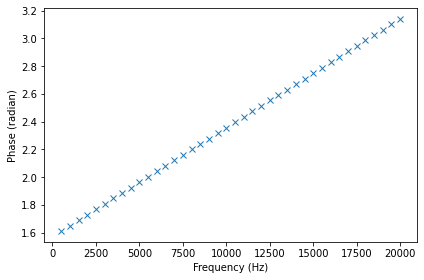

In [8]:
plot_angle(spectrum, thresh=1)

The following function plots the amplitudes, angles, and waveform for a given spectrum. 

In [9]:
def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.
    
    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

So we can visualize the unmodified spectrum:

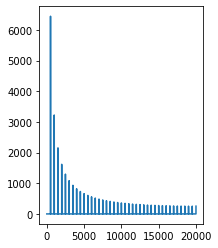

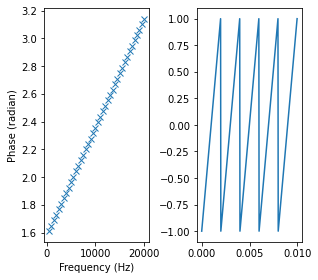

In [10]:
plot_three(spectrum)

Now let's see what happens if we set all the angles to zero.

In [11]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

The amplitudes are unchanged, the angles are all zero, and the waveform looks very different.  But the wave sounds pretty much the same.

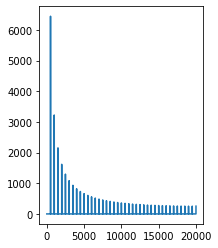

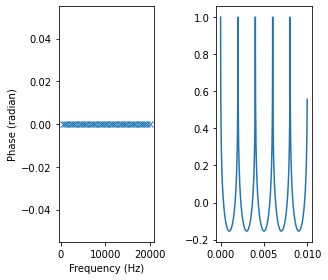

In [12]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

You might notice that the volume is lower, but that's because of the way the wave gets normalized; that's not because of the changes in the phase structure.

If we multiply the complex components by $\exp(i\phi)$, it has the effect of adding $\phi$ to the angles:

In [13]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

We can see the effect in the figure below.  Again, the wave form is different, but it sounds pretty much the same.

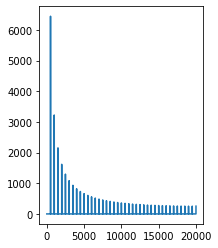

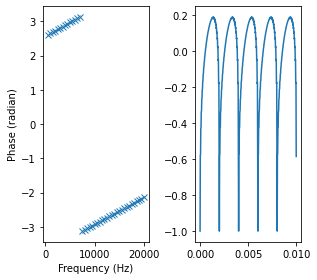

In [14]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3)

Finally, let's see what happens if we set the angles to random values.

In [15]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

The effect on the waveform is profound, but the perceived sound is the same.

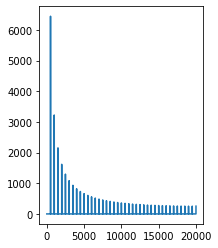

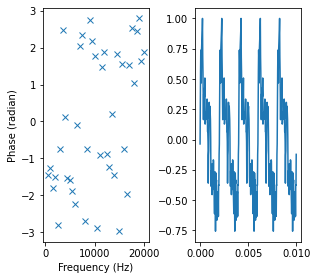

In [16]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4)

### Oboe

Let's see what happens with more natural sounds.  Here's recording of an oboe.

In [17]:
if not os.path.exists('120994__thirsk__120-oboe.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/120994__thirsk__120-oboe.wav

In [18]:
from thinkdsp import read_wave

wave = read_wave('120994__thirsk__120-oboe.wav')
wave.make_audio()

I'll select a segment where the pitch is constant.

In [19]:
segment = wave.segment(start=0.05, duration=0.9)

Here's what the original looks like.

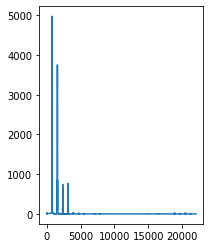

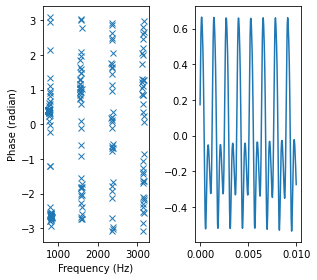

In [20]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Here it is with all angles set to zero.

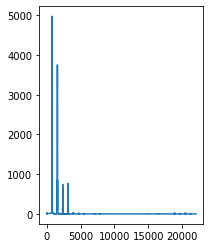

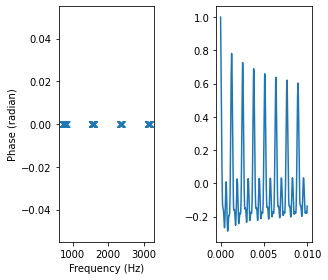

In [21]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Changing the phase structure seems to create a "ringing" effect, where volume varies over time.

Here it is with the angles rotated by 1 radian.

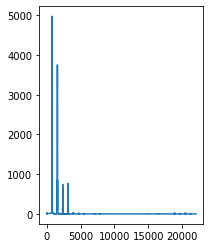

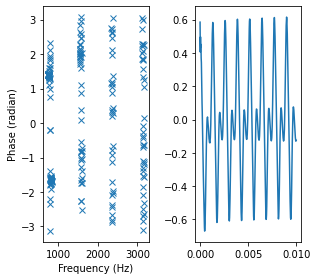

In [22]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Rotating the angles doesn't seem to cause ringing.

And here it is with randomized angles.

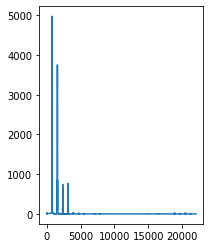

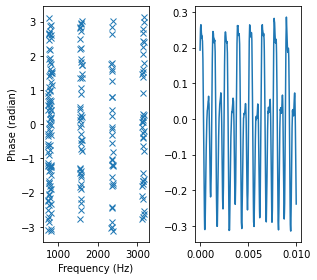

In [23]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Randomizing the angles seems to cause some ringing, and adds a breathy quality to the sound.

### Saxophone

Let's try the same thing with a segment from a recording of a saxophone.

In [24]:
if not os.path.exists('100475__iluppai__saxophone-weep.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav

In [25]:
wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()
segment = wave.segment(start=1.9, duration=0.6)

The original:

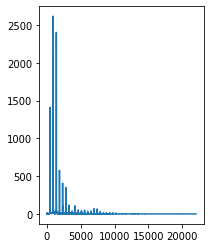

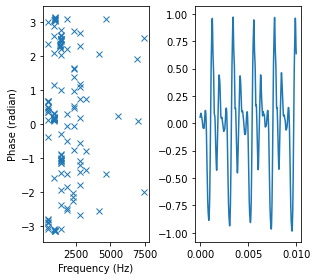

In [26]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Set angles to 0.

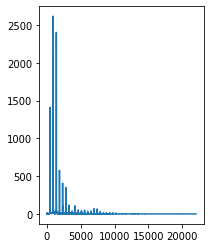

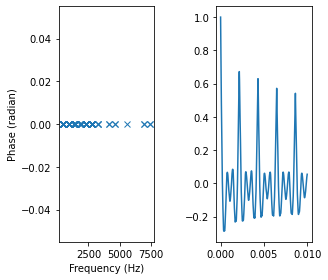

In [27]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Rotate angles by 1 radian.

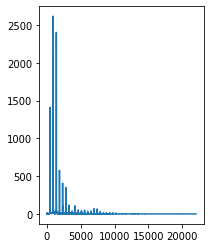

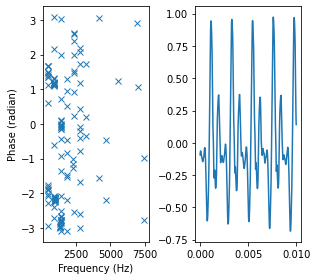

In [28]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Randomize the angles.

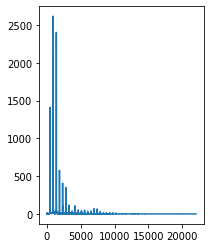

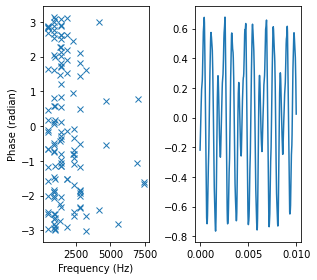

In [29]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Again, zeroing seems to create ringing, rotating has little effect, and randomizing adds a breathy quality.

One way the saxophone differs from the other sounds is that the fundamental component is not dominant.  For sounds like that, I conjecture that the ear uses something like autocorrelation in addition to spectral analysis, and it's possible that this secondary mode of analysis is more sensitive to phase structure.

If so, the effect should be more profound when the fundamental is missing altogether.


### Saxophone with missing fundamental

Let's run these steps one more time after filtering out the fundamental.

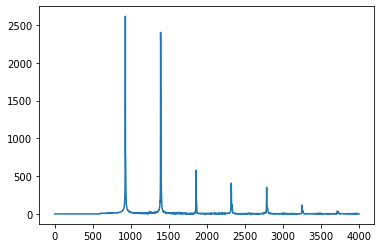

In [30]:
spectrum.high_pass(600)
spectrum.plot(high=4000)

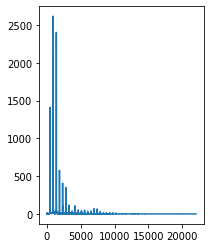

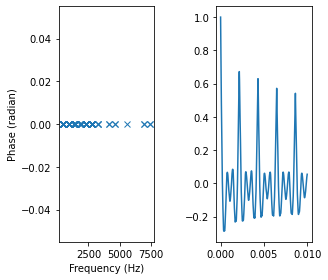

In [31]:
plot_three(spectrum2, thresh=50)

Zeroing

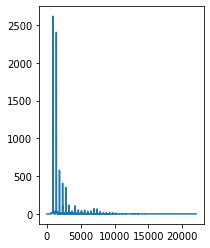

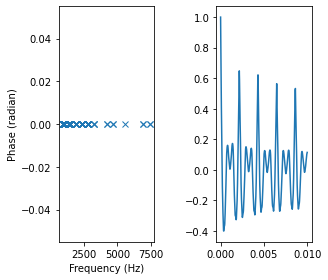

In [32]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Rotating

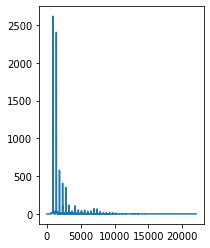

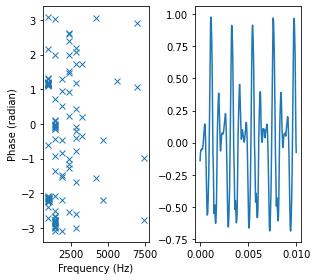

In [33]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Randomizing

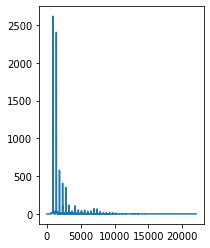

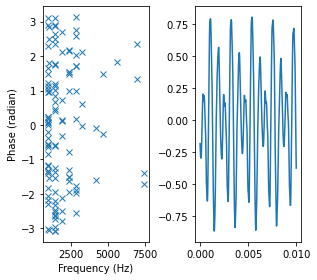

In [34]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

In summary:

1.  At least for sounds that have simple harmonic structure, it seems like we are mostly "phase blind"; that is, we don't hear changes in the phase structure, provided that the harmonic structure is unchanged.

2.  A possible exception is sounds with low amplitude at the fundamental frequency.  In that case we might use something autocorrelation-like to perceive pitch, and there are hints that this analysis might be more sensitive to the phase structure.